### Данные
В качестве данных были использованы:
- название канала
- описание канала
- название видео-роликов канала
- описание под видео-роликами канала

In [3]:
import pandas as pd

data = pd.read_csv('result.csv', sep='|')
data.head(100)

,название_канала,ссылка_на_канал,описание_канала,Названия_видео_роликов,метка_класса
0,A4,http://www.youtube.com/channel/UC2tsySbe9TNrI-...,"Канал называется А4, почему так? Тебе нужно за...","1,000 ЗАДАНИЙ за 24 ЧАСА ЧЕЛЛЕНДЖ ! ** 3 Часть...","Развлечения, Юмор"
1,Kuplinov ► Play,http://www.youtube.com/channel/UCdKuE7a2QZeHPh...,"Здесь можно поржать, отложить кирпичей, снять ...",ПРЕДАТЕЛЬ ► Resident Evil HD Remaster #7\nВСЕЛ...,"Юмор, Игры"
2,Натурал Альбертович,http://www.youtube.com/channel/UCE7f6y9VGVdZEt...,Всем спасибо за подписку❤️,СМЕШНЫЕ ВИДЕО СБОРНИК / ЮМОР и ПРИКОЛЫ / Свежи...,Юмор
3,ExileShow,http://www.youtube.com/channel/UC6JRrn_7Qe1CZB...,"Я не знаю, зачем создал этот канал, но он врод...","Самый Везучий Выиграет 200.000! (Горилла, Коре...",Развлечения
4,Gufee.medalin,http://www.youtube.com/channel/UC7VUPJfRyt57Xo...,❌Самый молодой режиссёр страны❌,ТРЕТИЙ ЭТАП ОТНОШЕНИЙ - ТРЕЙЛЕР СЕРИАЛА (ПРЕМЬ...,Кино
...,...,...,...,...,...
95,Yan Reyzen,http://www.youtube.com/channel/UC85pOvkr5egVA3...,Всем привет! С вами Ян Рейзен с:,Как Я Отметил 14 ФЕВРАЛЯ в Другой Стране (и по...,Развлечения
96,° ๑ Чудо-Чай ๑ °,http://www.youtube.com/channel/UCBVtlxZExSEsia...,"Всем морковный привет, меня зовут Чудо-Чай 🐰🥕",ОББИ НА ДВОИХ с ХолиБамом! Teamwork Puzzles 🧩 ...,Игры
97,MILANA STAR,http://www.youtube.com/channel/UCBpKZtuLooxjSm...,Официальный YouTube канал юной певицы Milana Star,"MILANA STAR - хит ""Малявка"" (официальное виде...",Музыка
98,А на даче жизнь иначе!,http://www.youtube.com/channel/UCXk07_I__uaDYi...,Телеграм: https://t.me/a_na_dache,24 декабря 2023г Сохраняю и размножаю махровый...,Лайфстайл


## Предобработка

In [2]:
from cleantext import clean
import re
from datasets import Dataset
from sklearn.preprocessing import MultiLabelBinarizer


def clean_text(text):
    text = clean(
        text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=True,
        no_currency_symbols=True,
        no_punct=True,
        no_emoji=True,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_digit="",
        lang="ru",
    )

    text = re.sub(r'►|---', '', text)
    return text


data['название_канала'] = data['название_канала'].apply(clean_text)
data['описание_канала'] = data['описание_канала'].apply(clean_text)
data['Названия_видео_роликов'] = data['Названия_видео_роликов'].apply(clean_text)
data.dropna(subset=['название_канала', 'описание_канала', 'Названия_видео_роликов', 'метка_класса'], inplace=True)
data['combined_text'] = data['название_канала'] + ' ' + data['описание_канала'] + ' ' + data['Названия_видео_роликов']

mlb = MultiLabelBinarizer()
data['метка_класса'] = data['метка_класса'].apply(lambda x: x.split(', '))
data['labels_encoded'] = list(mlb.fit_transform(data['метка_класса']))

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


### Токенизация

In [3]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split

processed_data = pd.DataFrame({
    'text': data['combined_text'],
    'label': data['labels_encoded'].apply(
        lambda x: [float(label) for label in x]
    ),
})

train_data, val_data = train_test_split(processed_data, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")


def preprocess_function(examples):
    result = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )
    result['labels'] = examples['label']
    return result


train_dataset = train_dataset.map(preprocess_function, batched=True).with_format("torch")
val_dataset = val_dataset.map(preprocess_function, batched=True).with_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", max_length=512, return_tensors="pt")

print(f"Размер тренировочного датасета: {len(train_dataset)}")
print(f"Размер валидационного датасета: {len(val_dataset)}")

Map:   0%|          | 0/4192 [00:00<?, ? examples/s]

Map:   0%|          | 0/1049 [00:00<?, ? examples/s]

In [4]:
train_dataset[0]

{'text': 'спецназ шоу россии eventшоу swat show первая федеральная компания россии предложение руки в коттедже обэп работает спецназ шоу россии город рязань пенза swat show настоящее шоу разборки на корпоративе спецназ шоу россии город санктпетербург swat show кольцо и граната предложение руки и сердца спецназ шоу россии город краснодар swat show день рождения спецназ шоу россии город челябинск екб special forces in russia swat show новости спнш на передовой сво вернемся с победой коллектив спецназ шоу россии принимает активное участие в сво работает спецназ шоу россии лютый хабаровск профессионалы своего дела мы самые первые swat show ук рф встряска спецназ шоу россии город краснодар с днем рождения swat show спецназ шоу на съемках клипа операция легализация ст ч ук рф спецназ шоу армавир special forces in russia swat show операция тишина ук рф спецназ шоу россии представляет город краснодар special forces in russia поздравил подругу ст ук рф спецназ шоу иркутск special forces in russ

In [5]:
processed_data

,text,label
0,a канал называется а почему так тебе нужно зай...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,kuplinov play здесь можно поржать отложить ки...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,натурал альбертович всем спасибо за подписку с...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,exileshow я не знаю зачем создал этот канал но...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
4,gufeemedalin самый молодой режиссёр страны тре...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
5246,nur dekhkonov выкладываю на канал свои работы ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5247,qugmenov страх бронз nan,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5248,tatyna zandai сделаем мир лучшевместе таалай к...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5249,в мире смешных канал в мире смешных открой две...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
data_collator

DataCollatorWithPadding(tokenizer=BertTokenizerFast(name_or_path='bert-base-multilingual-cased', vocab_size=119547, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding='max_length', max_length=512, pad_to_multiple_of=None, return_tensors='p

In [7]:
print(f"Размер тренировочного датасета: {len(train_dataset)}")
print(f"Размер валидационного датасета: {len(val_dataset)}")

Размер тренировочного датасета: 4192
Размер валидационного датасета: 1049


### Оценим распределение классов

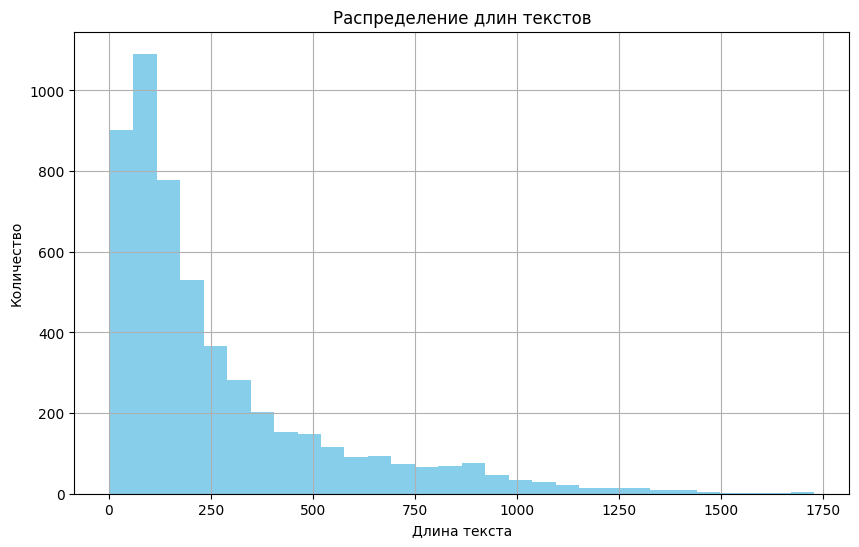

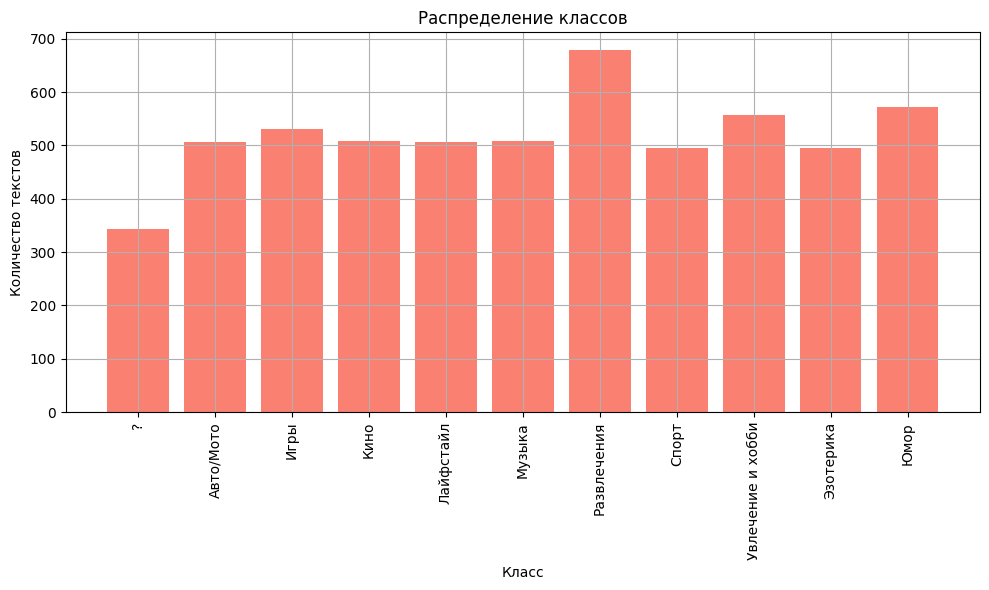

Минимальная длина текста: 2
Максимальная длина текста: 1728
Средняя длина текста: 262.484449532532
Медианная длина текста: 162.0


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

text_lengths = [len(text.split()) for text in data['combined_text']]

min_length = min(text_lengths)
max_length = max(text_lengths)
average_length = np.mean(text_lengths)
median_length = np.median(text_lengths)

plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='skyblue')
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

mlb = MultiLabelBinarizer()
labels_encoded = mlb.fit_transform(data['метка_класса'])
class_counts = np.sum(labels_encoded, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(mlb.classes_, class_counts, color='salmon')
plt.title('Распределение классов')
plt.xticks(rotation=90)
plt.xlabel('Класс')
plt.ylabel('Количество текстов')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Минимальная длина текста: {min_length}")
print(f"Максимальная длина текста: {max_length}")
print(f"Средняя длина текста: {average_length}")
print(f"Медианная длина текста: {median_length}")


### Тестовый запуск чтоб убедиться что ничего не сломано

In [9]:
from transformers import AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=11)

sample_input = torch.tensor(train_dataset[0]['input_ids']).unsqueeze(0)
outputs = model(sample_input)
outputs.logits

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\dagafonov\AppData\Local\Temp\ipykernel_163616\3598768324.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_input = torch.tensor(train_dataset[0]['input_ids']).unsqueeze(


tensor([[ 0.0155, -0.3427, -0.0257,  0.0825,  0.0638,  0.1032, -0.0798,  0.1892,
          0.1006,  0.1157,  0.3080]], grad_fn=<AddmmBackward0>)

## Обучение

In [10]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

mlb.fit(data['метка_класса'])
label2id = {label: index for index, label in enumerate(mlb.classes_)}
id2label = {index: label for label, index in label2id.items()}

In [11]:
id2label

{0: '?',
 1: 'Авто/Мото',
 2: 'Игры',
 3: 'Кино',
 4: 'Лайфстайл',
 5: 'Музыка',
 6: 'Развлечения',
 7: 'Спорт',
 8: 'Увлечение и хобби',
 9: 'Эзотерика',
 10: 'Юмор'}

In [12]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, jaccard_score


def compute_metrics(eval_pred, threshold=0.5):
    logits, labels = eval_pred
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()
    predictions = (probabilities > threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='micro')
    acc = accuracy_score(labels, predictions)
    jaccard = jaccard_score(labels, predictions, average='micro')

    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall, 'jaccard': jaccard}

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    problem_type="multi_label_classification",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)

training_args = TrainingArguments(
    output_dir="./best_super_model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    warmup_steps=50,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Jaccard
1,0.209300,0.206042,0.483317,0.582660,0.750347,0.476232,0.411094
2,0.172800,0.167328,0.530982,0.655720,0.866860,0.527289,0.487785
3,0.149200,0.169172,0.591039,0.665352,0.755879,0.594190,0.498523
4,0.135500,0.161397,0.614871,0.695309,0.791901,0.619718,0.532930
5,0.112500,0.175057,0.616778,0.680037,0.723214,0.641725,0.515194
6,0.078100,0.192667,0.601525,0.673197,0.681081,0.665493,0.507383
7,0.067300,0.196475,0.612011,0.666364,0.686916,0.647007,0.499660
8,0.057500,0.202338,0.616778,0.674688,0.683213,0.666373,0.509079
9,0.029300,0.209624,0.608198,0.676354,0.676652,0.676056,0.510978
10,0.030400,0.212322,0.614871,0.678761,0.682384,0.675176,0.513731


TrainOutput(global_step=7860, training_loss=0.07891029937538785, metrics={'train_runtime': 2141.1485, 'train_samples_per_second': 29.367, 'train_steps_per_second': 3.671, 'total_flos': 1.654576007233536e+16, 'train_loss': 0.07891029937538785, 'epoch': 15.0})

##### Остановимся на модели имеющяя следующие метрики (4-я эпоха):
- val_loss: 0.161397
- accuracy: 0.614871
- F1: 0.695309
- Precision: 0.791901
- Recall: 0.619718
- Jaccard: 0.532930

#### Выводы:
- Ошибка на валидационных данных (Validation Loss) сначала снижается, но начиная с 5-ой эпохи начинает увеличиваться, что может свидетельствовать о начале переобучения модели
- Данная base-line модель без fine-tuning'а позволяет провести дальнейшие работы с целью улучшения качества и дальнейшего её развития, при условии что качество данных, подаваемое на вход (можно было взять и лучше, но уже не было времни чтоб брать и обучать по новой)
- Индекс Жаккара немного колеблется, что может указывать на проблемы с разделением классов в данных
- Значения точности (Precision) и полноты (Recall) слегка улучшаются, но не демонстрируют стабильности это мы также можем соответственно увидеть на F1-мере

#### Дальнейший план действий:
- собрать больше данных
- увеличить разнородность семантики данных (изначально хотел брать субтитры с каждого ролика и обрабатывать именно их, таким образом пулл данных будет сильно больше чем текущий и сильно разнородней, также вероятно (гипотеза) позволит модели лучше понимать к какой категории относится тот или иной канал основываясь уже на его контекте, который обладает уже более специфичным представлением
- сделать агументацию 
- провести тщательный поиск гиперпараметров, он же fine-tuning поиграться со скоростью обучения



In [12]:
import torch

torch.cuda.empty_cache()

In [4]:
from tensorboard import notebook

# Загрузите TensorBoard и отобразите логи
notebook.start("--logdir ./logs")

Launching TensorBoard...

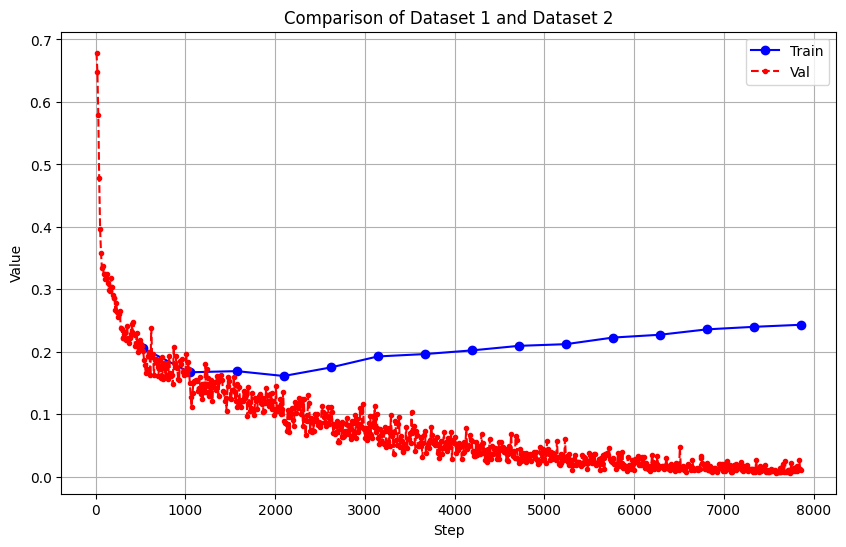

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('logs/plots/train_loss.csv')
df2 = pd.read_csv('logs/plots/val_loss.csv')

plt.figure(figsize=(10, 6))

plt.plot(df1['Step'], df1['Value'], label='Train', marker='o', linestyle='-', color='blue')
plt.plot(df2['Step'], df2['Value'], label='Val', marker='.', linestyle='--', color='red')

plt.title('Comparison of Dataset 1 and Dataset 2')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()

# Display the plot with grid
plt.grid(True)
plt.show()


In [6]:
!pwd

/Users/arslan/Desktop/Test_Media/train
